In [2]:
import openeo
import xarray as xr


In [12]:



connection = openeo.connect(
    url="openeo.dataspace.copernicus.eu",
)
connection.authenticate_oidc()


Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [14]:

spatial_extent = {"type":"Polygon","coordinates":[[[10.838356,43.727445],[10.568848,43.727445],[10.568848,43.859039],[10.838356,43.859039],[10.838356,43.727445]]]}


In [ ]:

s1_crisis = connection.load_collection(
    "SENTINEL1_GRD",
    spatial_extent = spatial_extent  ,
    temporal_extent=["2025-03-16", "2025-03-18"],
    bands=["VV"],
)

s1_archive = connection.load_collection(
    "SENTINEL1_GRD",
    spatial_extent = spatial_extent  ,
    temporal_extent=["2024-08-19", "2024-08-21"],
    bands=["VV"],
)

In [3]:
s1_crisis_scatter = s1_crisis.sar_backscatter(
    coefficient="sigma0-ellipsoid", elevation_model="COPERNICUS_30"
)
s1_crisis_s = s1_crisis_scatter.apply(lambda x: 10 * x.log(base=10))

s1_archive_scatter = s1_archive.sar_backscatter(
    coefficient="sigma0-ellipsoid", elevation_model="COPERNICUS_30"
)
s1_archive_s = s1_archive_scatter.apply(lambda x: 10 * x.log(base=10))

In [4]:
s1_crisis_s.execute_batch("s1_crisis.nc",title="s1_crisis")
s1_archive_s.execute_batch("s1_archive.nc",title="s1_archive")

0:00:00 Job 'j-250506134644404aab3781f542d8f134': send 'start'
0:00:13 Job 'j-250506134644404aab3781f542d8f134': created (progress 0%)
0:00:18 Job 'j-250506134644404aab3781f542d8f134': created (progress 0%)
0:00:24 Job 'j-250506134644404aab3781f542d8f134': running (progress N/A)
0:00:32 Job 'j-250506134644404aab3781f542d8f134': running (progress N/A)
0:00:42 Job 'j-250506134644404aab3781f542d8f134': running (progress N/A)
0:00:55 Job 'j-250506134644404aab3781f542d8f134': running (progress N/A)
0:01:10 Job 'j-250506134644404aab3781f542d8f134': running (progress N/A)
0:01:29 Job 'j-250506134644404aab3781f542d8f134': finished (progress 100%)
0:00:00 Job 'j-25050613481545bba9918cb8ba2f57b6': send 'start'
0:00:12 Job 'j-25050613481545bba9918cb8ba2f57b6': created (progress 0%)
0:00:17 Job 'j-25050613481545bba9918cb8ba2f57b6': created (progress 0%)
0:00:23 Job 'j-25050613481545bba9918cb8ba2f57b6': created (progress 0%)
0:00:31 Job 'j-25050613481545bba9918cb8ba2f57b6': created (progress 0%)
0:

<BatchJob job_id='j-25050613481545bba9918cb8ba2f57b6'>

In [4]:
s1_crisis_ds = xr.open_dataset("s1_crisis.nc")
s1_archive_ds = xr.open_dataset("s1_archive.nc")

vv_crisis = s1_crisis_ds['VV']
vv_archive = s1_archive_ds['VV']

### Histogram

Text(0, 0.5, 'Frequency')

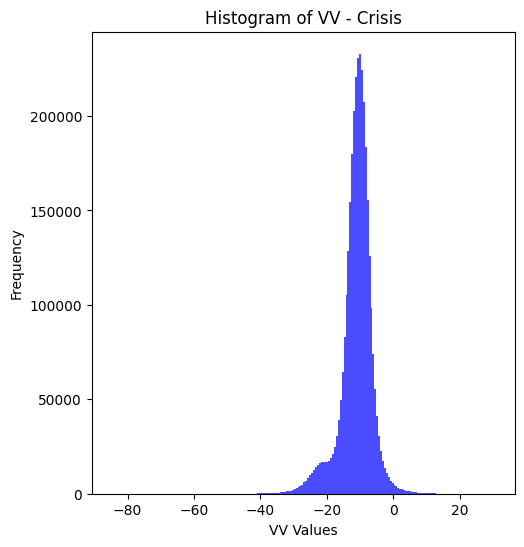

In [55]:
import matplotlib.pyplot as plt

# Converte i dati in un array NumPy e appiattiscilo
vv_crisis_flat = vv_crisis.values.flatten()

# Visualizza l'istogramma per la banda VV del dataset di crisi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(vv_crisis_flat, bins=200, color='blue', alpha=0.7)
#plt.xlim(-21, -18) #zoom by limiting x-axis
plt.title('Histogram of VV - Crisis')
plt.xlabel('VV Values')
plt.ylabel('Frequency')

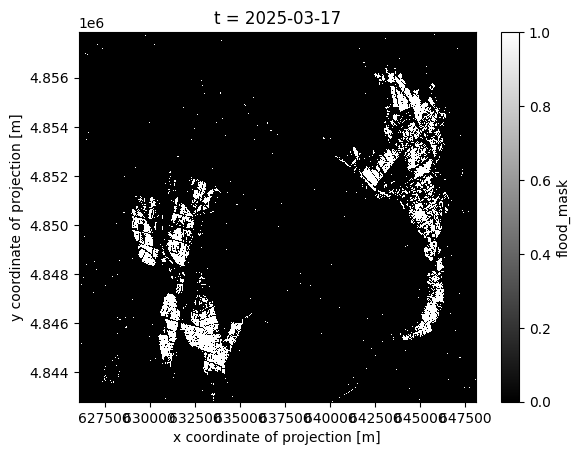

In [5]:
threshold = -19.5  # Soglia di esempio, da adattare in base ai tuoi dati

# Crea la maschera di inondazione
flood_mask_crisis = (vv_crisis < threshold).astype(int)
s1_crisis_ds['flood_mask'] = flood_mask_crisis

s1_crisis_ds['flood_mask'].plot(cmap='binary_r')

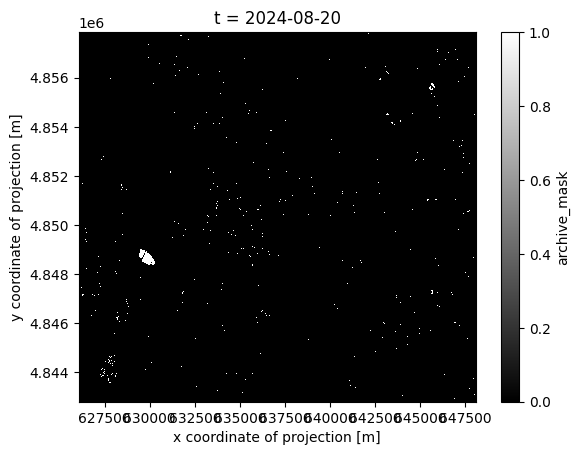

In [6]:
# Crea la maschera di archive
flood_mask_archive = (vv_archive < threshold).astype(int)
s1_archive_ds['archive_mask'] = flood_mask_archive
s1_archive_ds['archive_mask'].plot(cmap='binary_r')

In [40]:
s1_crisis_ds

<xarray.Dataset> Size: 40MB
Dimensions:     (t: 1, x: 2200, y: 1507)
Coordinates:
  * t           (t) datetime64[ns] 8B 2025-03-17
  * x           (x) float64 18kB 6.261e+05 6.261e+05 ... 6.481e+05 6.481e+05
  * y           (y) float64 12kB 4.858e+06 4.858e+06 ... 4.843e+06 4.843e+06
Data variables:
    crs         |S1 1B b''
    VV          (t, y, x) float32 13MB -7.601 -9.607 -10.56 ... -6.629 -5.612
    flood_mask  (t, y, x) int64 27MB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.65.0a12.dev2...
    description:  
    title:

In [ ]:
s1_crisis_ds.rio.crs

In [43]:
difference_map = s1_crisis_ds['flood_mask'].values - s1_archive_ds['archive_mask'].values

difference = xr.DataArray(difference_map, coords={ 't': s1_crisis_ds.t.values,'x': s1_crisis_ds.x.values, 'y': s1_crisis_ds.y.values, 
                               },
             dims=['t', 'y', 'x'],attrs=s1_crisis_ds.attrs)

difference.rio.write_crs("epsg:32632", inplace=True)

<xarray.DataArray (t: 1, y: 1507, x: 2200)> Size: 27MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 1507, 2200))
Coordinates:
  * t            (t) datetime64[ns] 8B 2025-03-17
  * x            (x) float64 18kB 6.261e+05 6.261e+05 ... 6.481e+05 6.481e+05
  * y            (y) float64 12kB 4.858e+06 4.858e+06 ... 4.843e+06 4.843e+06
    spatial_ref  int64 8B 0
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.65.0a12.dev2...
    description:  
    title:

In [42]:
difference

<xarray.DataArray (t: 1, y: 1507, x: 2200)> Size: 27MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 1507, 2200))
Coordinates:
  * t        (t) datetime64[ns] 8B 2025-03-17
  * x        (x) float64 18kB 6.261e+05 6.261e+05 ... 6.481e+05 6.481e+05
  * y        (y) float64 12kB 4.858e+06 4.858e+06 ... 4.843e+06 4.843e+06
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.65.0a12.dev2...
    description:  
    title:

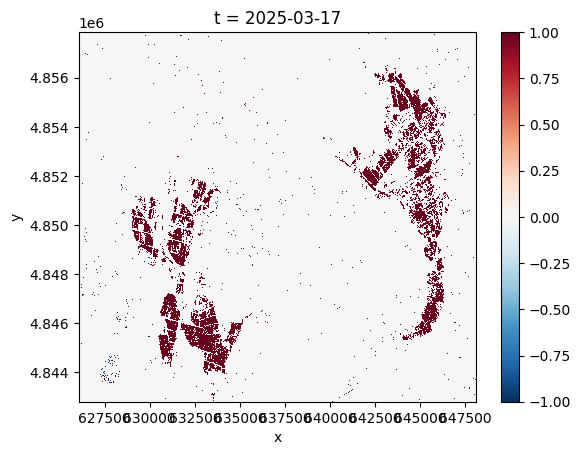

In [8]:
difference.plot()

In [1]:
import rioxarray

In [44]:
difference.rio.to_raster('difference_map.tif')

In [15]:
dem = connection.load_collection(
    "COPERNICUS_30",
    spatial_extent = spatial_extent  ,
    #temporal_extent=["2024-08-19", "2024-08-21"],
    bands=["DEM"],
)

In [16]:
dem.download('dem.tif')